<a href="https://colab.research.google.com/github/hereagain-Y/TF_tutorial/blob/main/VAE_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [4]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784 # 28*28
hidden_dim = 400 
latent_dim = 200

lr = 1e-3

epochs = 30

## Download dataset

In [5]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST('~/datasets', transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST('~/datasets', transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)


Step 2. Define our model: Variational AutoEncoder (VAE)

In [6]:

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [7]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [8]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var) ]
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [9]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

Step 3. Define Loss function (reprod. loss) and optimizer

In [10]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

Step 4. Train Variational AutoEncoder (VAE)

In [11]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  173.34985509703674
	Epoch 2 complete! 	Average Loss:  128.50101220132512
	Epoch 3 complete! 	Average Loss:  117.33262737700855
	Epoch 4 complete! 	Average Loss:  112.72798965071995
	Epoch 5 complete! 	Average Loss:  110.1274566497548
	Epoch 6 complete! 	Average Loss:  108.47997336054883
	Epoch 7 complete! 	Average Loss:  107.3307808913293
	Epoch 8 complete! 	Average Loss:  106.23585319608202
	Epoch 9 complete! 	Average Loss:  105.58968777715464
	Epoch 10 complete! 	Average Loss:  105.09235451012104
	Epoch 11 complete! 	Average Loss:  104.46893236774834
	Epoch 12 complete! 	Average Loss:  104.08129625221724
	Epoch 13 complete! 	Average Loss:  103.6209027252452
	Epoch 14 complete! 	Average Loss:  103.3378409654111
	Epoch 15 complete! 	Average Loss:  103.02838731870827
	Epoch 16 complete! 	Average Loss:  102.7406930007043
	Epoch 17 complete! 	Average Loss:  102.38407539584203
	Epoch 18 complete! 	Average Loss:  102.15611817221411
	E

Step 5. Generate images from test dataset

In [12]:
import matplotlib.pyplot as plt

In [13]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [14]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

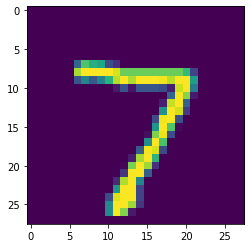

In [15]:
show_image(x, idx=0)

In [ ]:
show_image(x_hat, idx=0)

Step 6. Generate image from noise vector

In [16]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [17]:

save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

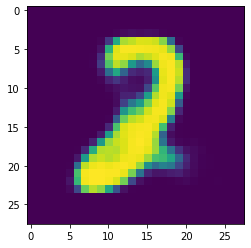

In [18]:
show_image(generated_images, idx=12)

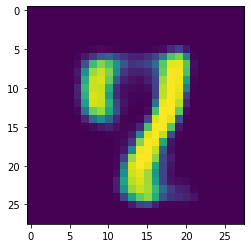

In [19]:
show_image(generated_images, idx=50)